## Train and Evaluate a Keras-Based Classifier

- Create a Keras-based convolutional neural network (CNN) model.
- Train the CNN model on agricultural and non-agricultural land dataset.
- Evaluate the performance of the CNN model.

This notebook demonstrates the process of building, training, and evaluating a **Keras-based convolutional neural network (CNN)** for image classification, for agricultural images in our case. We will cover:
1. Data preparation
2. Model architecture definition
3. Training
4. Model performance analysis

The goal is to classify satellite images into two categories "agricultural" and "non-agricultural"

#### Step 1: Configuration and library imports

In [6]:
import os
import sys
import time
import shutil
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

##### TensorFlow environment configuration

This cell sets environment variables for TensorFlow.
- `TF_ENABLE_ONEDNN_OPTS` is set to "0" to disable Intel oneDNN optimizations, which can sometimes lead to issues or unwanted behaviour on specific hardware configurations. 
- `TF_CPP_MIN_LOG_LEVEL` is set to "2", instructing TensorFlow to only display warning and error messages from its C++ backend. This reduces verbose output and keeps the console cleaner, focusing on more critical information during model training.

In [7]:
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [8]:
extract_dir = ''

##### Import deep learning and ML libraries

Here is a brief description of the usage of the **Keras** libraries and methos that will be used:
- `Sequential` models are a linear stack of layers. 
- `Conv2D` and `MaxPooling2D` are fundamental for CNNs, extracting features and reducing dimensionality.
- `BatchNormalization` stabilizes training.
- `Dense` layers from the classifier.
- `Dropout` regularizes to prevent overfitting.
- `ImageDataGenerator` automates data loading and augmentation
- `HeUniform` is used for weight initialization.

**Scikit-learn** (`sklearn.metrics`) provides the following metrics for model performance assessment:
- `classification_report`
- `confusion_matrix`
- `accuracy_score`

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score


In [11]:
# Check the availability of GPU
gpu_list = tf.config.list_physical_devices("GPU")

device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu


We will just stick with CPU for now, due to the recent update.

In [13]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Here we fix the random seeds for `random` module, NumPy, and TensorFlow. By initiailizing these seeds with a constant value (for instance 42), any operations that involve randomness (such as weight initialization, data shuffling or data augmentation) will produce the excat same sequence of random number every time the code is ran. This is crucial for ensuring the reporducibility of experimental results and when comparing different models or hyperparameters.

In [14]:
# Define the datset path
dataset_path = os.path.join(extract_dir, "images_dataSAT")
print(dataset_path)

images_dataSAT


#### Step 2: Create the dataset file list

In [15]:
fnames = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        fnames.append(os.path.join(dirname, filename))
print(f"Total files in the dataset: {len(fnames)}")
nfname_print = 2
for f in fnames[:nfname_print]:
    print(f)
for f in fnames[-nfname_print:]:
    print(f)

Total files in the dataset: 6000
images_dataSAT\class_0_non_agri\tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_5902.jpg
images_dataSAT\class_0_non_agri\tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6074.jpg
images_dataSAT\class_1_agri\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQD_20250427T170513.SAFE_0805.jpg
images_dataSAT\class_1_agri\tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQD_20250427T170513.SAFE_0812.jpg


#### Step 3: Define the model hyperparameters

Hyperparameters are configurable values that are set before the training process begins.

This cell initializes several key hyperparameters that will govern the training process and the model's input. Here is the list of hyperparameters:
- `img_w` and `img_h` define the width and height for resizing input images. 
- `n_channels` defines the number of color channels (3 for RGB).
- `n_epochs` sets the total training iterations over the dataset. 
- `batch_size` sets the number of samples processes per batch in the epoch.
- `lr` defines the learning rate for the optimizer
- `steps_per_epoch` are total number of steps used for training. **None** means the number is calculated automatically.
- `validation_steps` are total number of steps used for validation the model on validation data. **None** means the number is calculated automatically.

These hyperparameters are crucial for controlling model performance and resource utilization and significantly influence a model's performance and training efficiency.

In [16]:
img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
lr = 0.001 
n_epochs = 3

steps_per_epoch = None
validation_steps = None

model_name = "ibm_ai_capstone_project.model.keras"

#### Step 4: Configure `ImageDataGenerator` for Augmentation

Augmenting data boosts model robustness against variations in real-world images. `ImageDataGenerator` performs these transformations on-the-fly, making it efficient for large datasets.

In [17]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2, 
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             fill_mode = "nearest", # specifies how new pixels are filled after transformations.
                             validation_split = 0.2 # reserves 20% of data for validation.
                             )

#### Step 4: Create training and validation data generators

`ImageDataGenerator` is used to create `train_generator` and `validation_generator`. The `flow_from_directory()` is a convenieint method of `ImageDataGenerator` for automatically creating data pipelines from structured image directories. The generator resize images to `(img_w, img_h)` and group them into `batch_size` chunks. `class_mode="binary"` indicated a two-class classification task.

The `subset` parameter is used to assign 80% of the data for training and 20% for validation based on the `validation_split`.

In [18]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size = batch_size,
    class_mode = "binary",
    subset = "training"
)

Found 4800 images belonging to 2 classes.


In [20]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (img_w, img_h),
    batch_size=batch_size,
    class_mode = "binary",
    subset="validation"
)

Found 1200 images belonging to 2 classes.


#### Step 5: Model definition and compilation

Define the convoutional neural network architecture

The model architecture is composed of several key components:
- `Sequential`, a linear stack of layers in Keras.
- **Conv2D** layers perform convolution operations, acting as feature detectors.
- **MaxPooling2D** reduces the spatial dimensions of the feature maps.
- **BatchNormalization** normalizes layer inputs, stabalizing and accelerating training.
- **GlobalAveragePooling2D** summarizes feature maps into a single vector, reducing parameters.
- **Dense** (fully connected) layers learn complex patterns from these features.
- **Dropout** is a regularization technique that randomly deactivates neurons during training.
- **Sigmoid** activation is used for binary classification, mapping outputs to probabilities.
- **HeUniform** initializer is suitable for ReLU activations.
- *The final output* `Dense` **layer** used a `sigmoid` activation for binary classificaiton, outputting a probability between 0 and 1.

In [23]:
model = Sequential([
    Conv2D(32, (5,5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (5,5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (5, 5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),

    ###
    Conv2D(256, (5,5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform()),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(512, (5,5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform()),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(1024, (5,5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform()),
    MaxPooling2D(),
    BatchNormalization(),

    ###
    GlobalAveragePooling2D(),

    Dense(64, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    ###
    Dense(512, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    Dense(1024, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    Dense(2048, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    ###
    Dense(1, activation="sigmoid")


])

#### Step 6: Compile the model and display the summary

Here we compile the model using `model.compile()` with the `Adam` optimizer and `learning_rate` equal to (0.001).

The `loss` function is specified as `"binary_crossentropy"`, appropriate for binary classification problems. `accuracy` is set as the performance `metric` to monitor training and evaluation. We print `model.summary()` for a detailed overview of the network.

In [25]:
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,352,897 (77.64 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

None


#### Step 7: Model training

Display the training configuration and hyperparameters

Here we pring a comprehensive summary of the training and list all critical hyperparameters. This detailed output serves as a quick reference and verification of the experimental setup. Before commencing computationally intensive tasks such as deep learning model training, it is a good practice to log and verify the configuration.

In [27]:
print(f"Training Hyperparameters:\n\
        n_classes (train) = {train_generator.num_classes},\n\
        n_classes (validation) = {validation_generator.num_classes},\n\
        img_w, img_h ={img_w, img_h},\n\
        n_channels = {n_channels},\n\
        batch_size = {batch_size},\n\
        steps_per_epoch = {steps_per_epoch},\n\
        n_epochs = {n_epochs},\n\
        validation_steps = {validation_steps},\n\
        learning_rate = {lr}"
    )

Training Hyperparameters:
        n_classes (train) = 2,
        n_classes (validation) = 2,
        img_w, img_h =(64, 64),
        n_channels = 3,
        batch_size = 128,
        steps_per_epoch = None,
        n_epochs = 3,
        validation_steps = None,
        learning_rate = 0.001


Save the model checkpoint

Now we declare a method to save the **best model** during training. The best model can be defined by either **lowest loss** or **high accuracy**.

In [30]:
# Create the ModelCheckpoint callback (checks for minimum loss)
checkpoint_cb = ModelCheckpoint(
    filepath = model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

Or we could also do:

In [31]:
# Create the ModelCheckpoint callback (checks for maximum accuracy)

checkpoint_cb = ModelCheckpoint(
    filepath = model_name,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    verbose = 1
)

#### Step 8: Execute model training

- `model.fir()` is the primary function for training a Keras model. It controls the entire training loop: iterating over epochs, fetching data batches from generators, performing foeward and backward passes, updating weights via the optimizer, and calculating loss and metrics.
- `steps_per_epoch` determines how many batches constitute an "epoch".
- `validation_data` and `validation_steps` allow monitoring of the model's generalization ability on a seperate dataset, helps in detecting overfitting.
- `callbacks` determines how the best model is saved.
- The `fit` object stores the model's training history.

In [32]:
print(f"Training on : ==={device}=== with batch size : {batch_size} & lr : {lr}")

fit = model.fit(
    train_generator,
    epochs = n_epochs,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks = [checkpoint_cb],
    verbose = 1
)

Training on : ===cpu=== with batch size : 128 & lr : 0.001
Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8671 - loss: 0.3666
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9629 - loss: 0.1361
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9700 - loss: 0.1055


You evaluate with the validation generator after training is complete, like this:

predictions = model.predict(validation_generator)

#### Step 9: Model evaluation and visualization

Perform a comprehensive model evaluaiton

Here, we will perform a detailed evaluation of the trained model on the validation dataset. We would calculate the necessary predictions `steps` based on the validation data and `batch_size`. Then, we will obtain the true class labels (`y_true`) and generate the model's predictions (`y_pred`) on the validation set. The predcited probabilities are converted to binary class labels using a 0.5 threshold. Finally, we will print the overall `accuracy_score`, to get a quantitative assessment of the model's perfoemance on unseen data.

Model evaluation metrics are essential for understanding a model's gemeralization ability. `y_true` represents the actual labels, while `y_pred` are the model's predicted labels. For binary classification, probabilities are converted to class labels by thresholding. The **accuracy score** is the proportion of correct predictions out of the total predictions.

In [35]:
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
batch_size = int(validation_generator.batch_size)

all_preds = []
all_labels = []
for step in range(steps):
    # Get one batch data
    images, labels = next(validation_generator)
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()
    all_preds.extend(preds)
    all_labels.extend(labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Score : {accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Accuracy Score : 0.4983


##### We can clearly see that our model is severly overfitting.

Let us try again but with a simpler model:

#### Step 10: Optimize model

In [37]:
model = Sequential([
    Conv2D(32, (5,5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform(), input_shape=(img_w, img_h, n_channels)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (5,5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (5, 5), activation="relu", padding="same", strides=(1,1), kernel_initializer=HeUniform()),
    MaxPooling2D(2,2),
    BatchNormalization(),

    ###
    GlobalAveragePooling2D(),

    Dense(64, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation="relu", kernel_initializer=HeUniform()),
    BatchNormalization(),
    Dropout(0.4),

    ###
    Dense(1, activation="sigmoid")
])

loss = "binary_crossentropy"
model.compile(optimizer=Adam(learning_rate=lr),
              loss=loss, 
              metrics=["accuracy"])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,169 (1.19 MB)

 Trainable params: 309,825 (1.18 MB)

 Non-trainable params: 1,344 (5.25 KB)

None


In [38]:
n_epochs = 10

print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

fit = model.fit(train_generator, 
                epochs= n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=(validation_generator),
                validation_steps = validation_steps,
                callbacks=[checkpoint_cb],
                verbose=1
               )

Training on : ===cpu=== with batch size: 128 & lr: 0.001
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8588 - loss: 0.3249
Epoch 1: val_accuracy improved from None to 0.69333, saving model to ibm_ai_capstone_project.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.9237 - loss: 0.1926 - val_accuracy: 0.6933 - val_loss: 0.5050
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9767 - loss: 0.0647
Epoch 2: val_accuracy improved from 0.69333 to 0.76667, saving model to ibm_ai_capstone_project.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 337ms/step - accuracy: 0.9740 - loss: 0.0716 - val_accuracy: 0.7667 - val_loss: 0.4853
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9801 - loss: 0.0538
Epoch 3: val_accuracy did not improve from 0.76667
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.9827 - loss: 0.0477 - val_accuracy: 0.4233 - val_loss: 1.4933
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9

In [39]:
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
batch_size = int(validation_generator.batch_size)

all_preds = []
all_labels = []
for step in range(steps):
    # Get one batch data
    images, labels = next(validation_generator)
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten() 
    all_preds.extend(preds)
    all_labels.extend(labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Score: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Accuracy Score: 0.9492


##### Much better.

#### Step 11: Visualize the training history (accuracy and loss)

This cell generates two plots to visualize the model's training performance, one for accuracy and one for loss, across epochs.

- **Accuracy** measures the prportion of correct predictions.
- Loss quantifies the error between prediction and true labels.
- Using these metrics, we can check the model for **overfitting** or **underfitting**.
- `fit.history` attribute stores these metrics for each epoch.

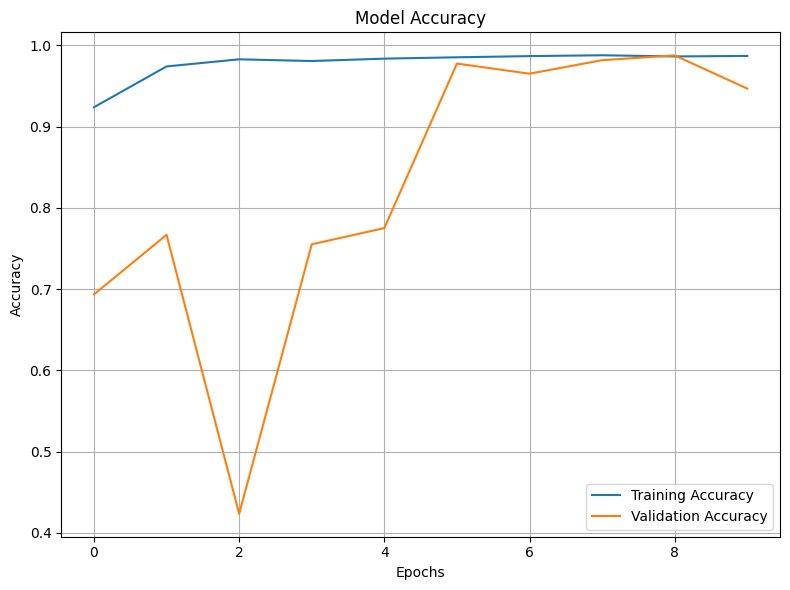

In [40]:
# Create a figure with a subplot
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history["accuracy"], label="Training Accuracy")
axs.plot(fit.history["val_accuracy"], label = "Validation Accuracy")
axs.set_title("Model Accuracy")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

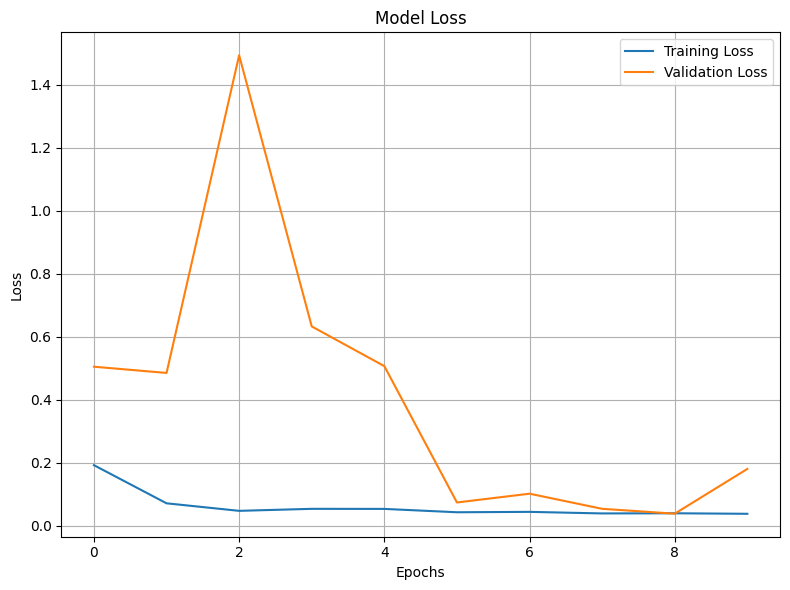

In [41]:
# Create a figure with a subplot
fig, axs = plt.subplots(figsize=(8, 6))

# Plot Accuracy on the first subplot
axs.plot(fit.history["loss"], label="Training Loss")
axs.plot(fit.history["val_loss"], label = "Validation Loss")
axs.set_title("Model Loss")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

Solid results. 